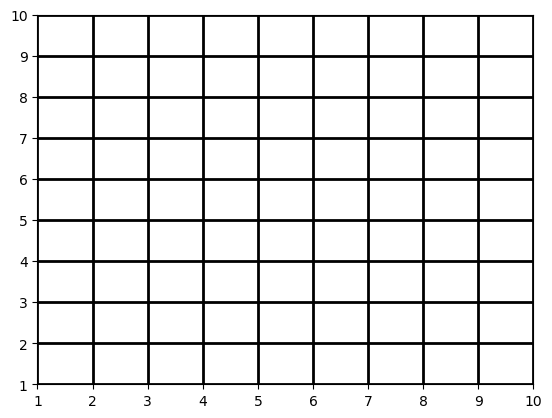

In [1]:
import gurobipy as gp
import matplotlib.pyplot as plt
import matplotlib.collections as cllc
from gurobipy import GRB

# Initialize grid:
plt.grid(color='black', linestyle='-', linewidth=2, zorder=0)
plt.xlim(1, 10)
plt.ylim(1, 10)

# Add a point on top of the grid:
def addPoint(x: int, y: int, col: str = 'red') -> cllc.PathCollection:
    plt.scatter(x, y, color=col, s=100, zorder=5)
    
# EX: addPoint(2, 3, 'blue')

In [2]:
grid_size = 10
coords = [(r,c) for r in range(1, grid_size+1) for c in range(1, grid_size+1)]

facility_names = ["school", "convenience", "hospital", "park", "fire", "police", "library", "gym", "bank", "post_office"]
max_facilities = {
    "school": 25,
    "hospital": 25,
    "police": 25,
    "fire": 25,
    "convenience": 25,
    "bank": 25,
    "gym": 25,
    "library": 25,
    "post_office": 25,
    "park": 25
}

def manhattan(a: int, b: int, c: int, d: int) -> int:
    return abs(a-c)+abs(b-d)

# Precompute distances!
dist = {(i, j): manhattan(i[0], i[1], j[0], j[1]) for i in coords for j in coords}

# Best and worst case:
T_min, T_max = 0, 2*(grid_size-1)

lo, hi = T_min, T_max
best_T = None
best_y = None

print(f"Starting binary search for T in range [{lo}, {hi}]...")

while lo <= hi:
    T = (lo + hi) // 2
    m = gp.Model(f"Cover_T_{T}")
    m.setParam("OutputFlag", 0)

    # y[name, i] if facility "name" is placed at i
    y = {
        name: {i: m.addVar(vtype=GRB.BINARY, name=f"y_{name}_{i}") for i in coords}
        for name in facility_names
    }

    # CONSTRAINT 1: Buildings can't overlap
    for i in coords:
        m.addConstr(gp.quicksum(y[name][i] for name in facility_names) <= 1)

    # CONSTRAINT 2: Enforce max # facilities
    for name in facility_names:
        m.addConstr(gp.quicksum(y[name][i] for i in coords) <= max_facilities[name])

    # CONSTRAINT 3: All points must be within 'T' of each type of facility
    for j in coords:
        close = [i for i in coords if dist[(i,j)] <= T]
        for name in facility_names:
            m.addConstr(gp.quicksum(y[name][i] for i in close) >= 1)

    m.setObjective(0, GRB.MINIMIZE) # Not seeking optimality; just feasible solutions
    m.optimize()

    if m.Status != GRB.INFEASIBLE: # Still feasible; attempt smaller distance 'T'
        best_T = T
        best_y = {name: {i: int(y[name][i].X + 0.5) for i in coords}
                  for name in facility_names}
        hi = T-1
    else: # Infeasible; 
        lo = T+1

# Results

if best_T is not None:
    total_facilities = sum(y_dict[i] for y_dict in best_y.values() for i in coords)
    
    print(f"✅ Final Result: Minimum Maximum Manhattan Distance (T_min) = **{best_T}**")
    print(f"Total facilities required: **{total_facilities}** (5 for each of the 10 types)")
else:
    sys.exit("❌ No feasible solution was found.")

Starting binary search for T in range [0, 18]...
Set parameter Username
Set parameter LicenseID to value 2749125
Academic license - for non-commercial use only - expires 2026-12-03
✅ Final Result: Minimum Maximum Manhattan Distance (T_min) = **3**
Total facilities required: **100** (5 for each of the 10 types)


In [3]:
# Sensitivity analyis for T
def solve_for_fixed_T(T_value):
    m_test = gp.Model(f"Sensitivity_T_{T_value}")
    m_test.setParam("OutputFlag", 0)

    # Decision variables y[name][i]
    y_test = {
        name: {i: m_test.addVar(vtype=GRB.BINARY, name=f"y_{name}_{i}") 
               for i in coords}
        for name in facility_names
    }

    # OBJECTIVE: minimize total facilities
    m_test.setObjective(
        gp.quicksum(y_test[name][i] 
                    for name in facility_names 
                    for i in coords),
        GRB.MINIMIZE
    )

    # CONSTRAINT 1: No overlap
    for i in coords:
        m_test.addConstr(
            gp.quicksum(y_test[name][i] for name in facility_names) <= 1
        )

    # CONSTRAINT 2: Max facilities by type
    for name in facility_names:
        m_test.addConstr(
            gp.quicksum(y_test[name][i] for i in coords) <= max_facilities[name]
        )

    # CONSTRAINT 3: Coverage constraint with fixed T_value
    for j in coords:
        close = [i for i in coords if dist[(i, j)] <= T_value]
        for name in facility_names:
            m_test.addConstr(
                gp.quicksum(y_test[name][i] for i in close) >= 1
            )

    # Optimize
    m_test.optimize()

    if m_test.Status == GRB.OPTIMAL:
        total_used = sum(
            int(y_test[name][i].X + 0.5) 
            for name in facility_names 
            for i in coords
        )
        return ("Feasible", total_used)
    else:
        return ("Infeasible", None)


# Run analysis for T* +- 1 and T* +- 2
print("\nSensitivity Analysis on T\n")

Ts_to_test = [best_T - 1, best_T, best_T + 1, best_T + 2]

results = []

for Ttest in Ts_to_test:
    if Ttest < 0:
        results.append((Ttest, "Invalid", None))
        continue

    status, tot = solve_for_fixed_T(Ttest)
    results.append((Ttest, status, tot))
    if status == "Feasible":
        print(f"T = {Ttest}: Feasible | Min Facilities = {tot}")
    else:
        print(f"T = {Ttest}: Infeasible")

# Pretty printed summary table
print("\n=== Sensitivity Summary ===")
print(f"{'T':>4} | {'Status':>10} | {'Facilities':>10}")
print("-" * 30)

for Tval, stat, fac in results:
    fac_str = str(fac) if fac is not None else "-"
    print(f"{Tval:>4} | {stat:>10} | {fac_str:>10}")



Sensitivity Analysis on T

T = 2: Infeasible
T = 3: Feasible | Min Facilities = 70
T = 4: Feasible | Min Facilities = 45
T = 5: Feasible | Min Facilities = 40

=== Sensitivity Summary ===
   T |     Status | Facilities
------------------------------
   2 | Infeasible |          -
   3 |   Feasible |         70
   4 |   Feasible |         45
   5 |   Feasible |         40


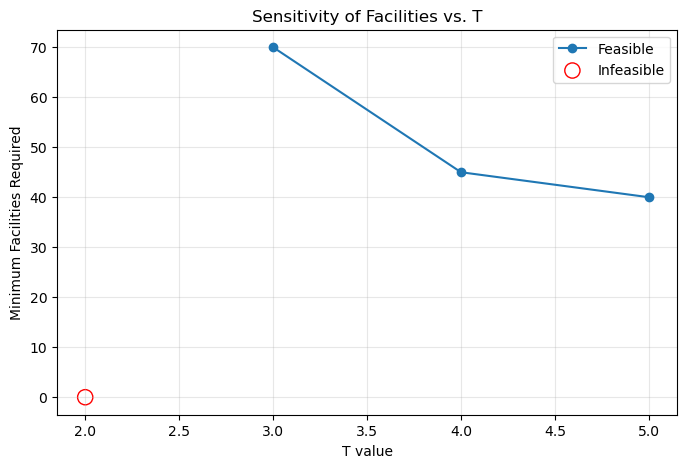

In [4]:
import matplotlib.pyplot as plt

# Extract values for plotting
T_vals = []
fac_vals = []

for Tval, status, fac in results:
    T_vals.append(Tval)
    # Infeasible → make the value None
    fac_vals.append(fac if status == "Feasible" else None)

# Plot
plt.figure(figsize=(8,5))

# Feasible points
plt.plot(
    [T for T, f in zip(T_vals, fac_vals) if f is not None], 
    [f for f in fac_vals if f is not None],
    marker='o', linestyle='-', label="Feasible"
)

# Infeasible points
plt.scatter(
    [T for T, f in zip(T_vals, fac_vals) if f is None],
    [0 for f in fac_vals if f is None],
    facecolors='none', edgecolors='red', s=120, label="Infeasible"
)

plt.title("Sensitivity of Facilities vs. T")
plt.xlabel("T value")
plt.ylabel("Minimum Facilities Required")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [5]:
# PHASE 2: Minimize facilities for the best found T

if best_T is None:
    print("\n❌ PHASE 1 failed to find a feasible T_min.")
else:
    print(f"\nPHASE 2: Minimizing Facilities for T_min = {best_T}")
    
    m_opt = gp.Model(f"Min_Facilities_T")
    m_opt.setParam("OutputFlag", 1)
    m_opt.setParam("MIPGap", 0)
    
    y_opt = {
        name: {i: m_opt.addVar(vtype=GRB.BINARY, name=f"y_opt_{name}_{i}") for i in coords}
        for name in facility_names
    }

    # NEW OBJECTIVE: Minimize total number of facilities
    m_opt.setObjective(
        gp.quicksum(y_opt[name][i] for name in facility_names for i in coords),
        GRB.MINIMIZE
    )
    
    # CONSTRAINT 1: No overlap
    for i in coords:
        m_opt.addConstr(gp.quicksum(y_opt[name][i] for name in facility_names) <= 1, name=f"Overlap_{i}")
    
    # CONSTRAINT 2: Max facilities
    for name in facility_names:
        m_opt.addConstr(gp.quicksum(y_opt[name][i] for i in coords) <= max_facilities[name], name=f"Max_{name}")
    
    # CONSTRAINT 3: Covering Constraint (Fixed maximum distance)
    for j in coords:
        for name in facility_names:
            # Use the fixed best T
            close_i = [i for i in coords if dist[(i,j)] <= best_T]
            m_opt.addConstr(gp.quicksum(y_opt[name][i] for i in close_i) >= 1, name=f"Cover_{name}_{j}")
            
    m_opt.optimize()


PHASE 2: Minimizing Facilities for T_min = 3
Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1110 rows, 1000 columns and 21600 nonzeros (Min)
Model fingerprint: 0x2d68436b
Model has 1000 linear objective coefficients
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 89.0000000
Presolve removed 120 rows and 0 columns
Presolve time: 0.01s
Presolved: 990 rows, 1000 columns, 19320 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 6.166667e+01, 4668 iterations, 0.21 seconds (0.61 work units

school at (1,7)
school at (2,3)
school at (4,9)
school at (5,3)
school at (8,6)
school at (10,1)
school at (10,10)
convenience at (1,4)
convenience at (3,9)
convenience at (5,1)
convenience at (6,5)
convenience at (8,10)
convenience at (9,2)
convenience at (10,5)
hospital at (1,1)
hospital at (2,8)
hospital at (4,5)
hospital at (6,3)
hospital at (7,10)
hospital at (9,3)
hospital at (9,7)
park at (1,5)
park at (3,10)
park at (4,1)
park at (5,8)
park at (8,4)
park at (9,9)
park at (10,3)
fire at (2,2)
fire at (2,6)
fire at (2,10)
fire at (5,6)
fire at (7,2)
fire at (8,9)
fire at (10,4)
police at (1,3)
police at (2,9)
police at (4,3)
police at (5,7)
police at (8,1)
police at (9,5)
police at (9,10)
library at (1,2)
library at (1,9)
library at (4,6)
library at (6,9)
library at (7,1)
library at (8,3)
library at (10,8)
gym at (1,10)
gym at (2,1)
gym at (2,5)
gym at (6,8)
gym at (7,3)
gym at (9,8)
gym at (10,2)
bank at (1,6)
bank at (3,2)
bank at (4,10)
bank at (6,6)
bank at (8,5)
bank at (9,1

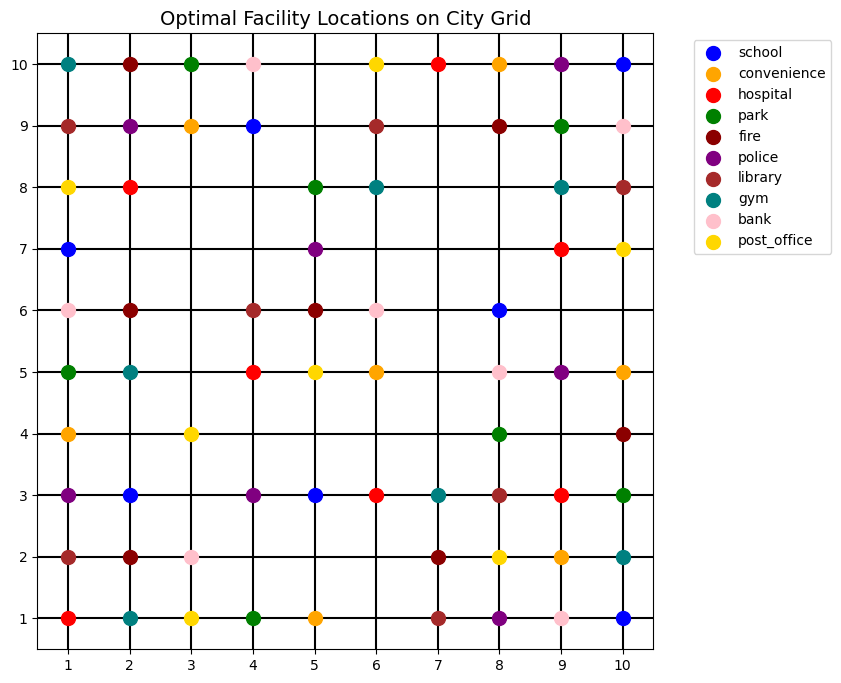

In [6]:
# Plot the 10x10 grid
plt.figure(figsize=(8, 8))
plt.grid(color='black', linestyle='-', linewidth=1.5, zorder=0)
plt.xlim(0.5, 10.5)
plt.ylim(0.5, 10.5)
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))
plt.gca().set_aspect('equal')

# Define color per facility type
facility_colors = {
    'school': 'blue',
    'convenience': 'orange',
    'hospital': 'red',
    'park': 'green',
    'fire': 'darkred',
    'police': 'purple',
    'library': 'brown',
    'gym': 'teal',
    'bank': 'pink',
    'post_office': 'gold'
}

# Plot facilities found in the optimal solution
for b in facility_names:
    for (i, j) in coords:
        if y_opt[b][i, j].X > 0.5:   # Facility exists
            print("%s at (%d,%d)" % (b, i, j))
            plt.scatter(i, j, color=facility_colors[b], s=100, label=b if b not in plt.gca().get_legend_handles_labels()[1] else "", zorder=3)

plt.title("Optimal Facility Locations on City Grid", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [7]:
# Limit each facility type to 6
print("\n\nSensitivity Analysis: Max 6 Facilities Per Type")

# Override limits
max_facilities_sensitivity = {name: 6 for name in facility_names}

def find_T_with_limit(limit_dict):
    lo, hi = 0, 2 * (grid_size - 1)
    best_T2 = None

    while lo <= hi:
        T = (lo + hi) // 2
        m2 = gp.Model(f"T_limit6_{T}")
        m2.setParam("OutputFlag", 0)

        y2 = {name: {i: m2.addVar(vtype=GRB.BINARY)
                     for i in coords}
              for name in facility_names}

        # No overlap
        for i in coords:
            m2.addConstr(gp.quicksum(y2[name][i] for name in facility_names) <= 1)

        # Max per type = 6
        for name in facility_names:
            m2.addConstr(gp.quicksum(y2[name][i] for i in coords) <= limit_dict[name])

        # Coverage
        for j in coords:
            close = [i for i in coords if dist[(i, j)] <= T]
            for name in facility_names:
                m2.addConstr(gp.quicksum(y2[name][i] for i in close) >= 1)

        m2.setObjective(0, GRB.MINIMIZE)
        m2.optimize()

        if m2.Status != GRB.INFEASIBLE:
            best_T2 = T
            hi = T - 1
        else:
            lo = T + 1

    return best_T2

T_limit6 = find_T_with_limit(max_facilities_sensitivity)
print(f"Minimum T with max 6 placements per type = {T_limit6}")



Sensitivity Analysis: Max 6 Facilities Per Type
Minimum T with max 6 placements per type = 4



Optimal Facility Count for T = 4
Minimum facilities required: 45

Facility placements for T = 4:
school: [(1, 2), (2, 9), (7, 5), (9, 1), (10, 10)]
convenience: [(2, 3), (3, 9), (6, 4), (8, 1), (9, 8)]
hospital: [(3, 3), (3, 8), (8, 3), (8, 8)]
park: [(1, 7), (4, 1), (7, 7), (7, 10), (10, 4)]
fire: [(2, 4), (4, 9), (7, 2), (9, 7)]
police: [(1, 4), (1, 8), (6, 8), (7, 1), (10, 7)]
library: [(2, 7), (4, 2), (7, 9), (9, 4)]
gym: [(1, 5), (5, 10), (6, 1), (10, 6)]
bank: [(1, 6), (5, 1), (6, 10), (10, 5)]
post_office: [(2, 2), (2, 8), (7, 6), (8, 2), (9, 10)]
school at (1,2)
school at (2,9)
school at (7,5)
school at (9,1)
school at (10,10)
convenience at (2,3)
convenience at (3,9)
convenience at (6,4)
convenience at (8,1)
convenience at (9,8)
hospital at (3,3)
hospital at (3,8)
hospital at (8,3)
hospital at (8,8)
park at (1,7)
park at (4,1)
park at (7,7)
park at (7,10)
park at (10,4)
fire at (2,4)
fire at (4,9)
fire at (7,2)
fire at (9,7)
police at (1,4)
police at (1,8)
police at (6,8)
pol

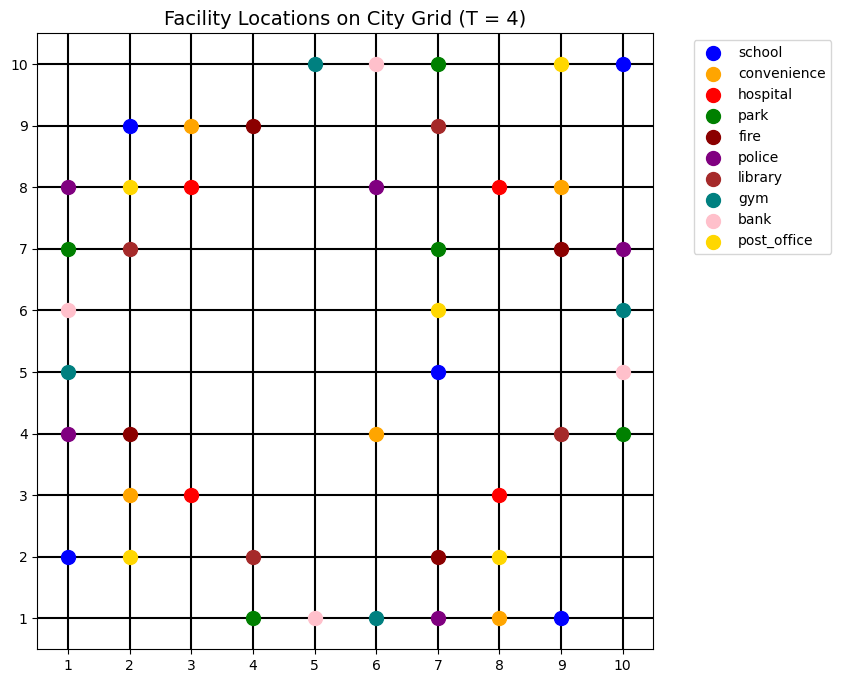

In [12]:
# imports
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# PHASE 2 re-run

grid_size = 10
coords = [(r,c) for r in range(1, grid_size+1) for c in range(1, grid_size+1)]
facility_names = ["school", "convenience", "hospital", "park", "fire", "police", "library", "gym", "bank", "post_office"]
max_facilities = {
    "school": 25,
    "hospital": 25,
    "police": 25,
    "fire": 25,
    "convenience": 25,
    "bank": 25,
    "gym": 25,
    "library": 25,
    "post_office": 25,
    "park": 25
}
def manhattan(a: int, b: int, c: int, d: int) -> int:
    return abs(a-c)+abs(b-d)

dist = {(i, j): manhattan(i[0], i[1], j[0], j[1]) for i in coords for j in coords}

T_value = 4

m_opt4 = gp.Model("Optimize_Facilities_T4")
m_opt4.setParam("OutputFlag", 0)

# Decision variables: y_opt4[name][i]
y_opt4 = {
    name: {i: m_opt4.addVar(vtype=GRB.BINARY, name=f"y4_{name}_{i}")
           for i in coords}
    for name in facility_names
}

# Objective: minimize total number of facilities
m_opt4.setObjective(
    gp.quicksum(y_opt4[name][i] 
                for name in facility_names 
                for i in coords),
    GRB.MINIMIZE
)

# Constraint 1: No overlap
for i in coords:
    m_opt4.addConstr(
        gp.quicksum(y_opt4[name][i] for name in facility_names) <= 1
    )

# Constraint 2: Max facilities per type
for name in facility_names:
    m_opt4.addConstr(
        gp.quicksum(y_opt4[name][i] for i in coords) <= max_facilities[name]
    )

# Constraint 3: Coverage with T = 4
for j in coords:
    close = [i for i in coords if dist[(i, j)] <= T_value]
    for name in facility_names:
        m_opt4.addConstr(
            gp.quicksum(y_opt4[name][i] for i in close) >= 1
        )

# Solve
m_opt4.optimize()

# Extract optimal placements
opt_facility_count_T4 = sum(
    int(y_opt4[name][i].X + 0.5)
    for name in facility_names
    for i in coords
)

print(f"\nOptimal Facility Count for T = 4")
print(f"Minimum facilities required: {opt_facility_count_T4}")

# Organize locations per facility type
opt_locations_T4 = {
    name: [i for i in coords if int(y_opt4[name][i].X + 0.5) == 1]
    for name in facility_names
}

print("\nFacility placements for T = 4:")
for name, locs in opt_locations_T4.items():
    print(f"{name}: {locs}")

# Plot the 10x10 grid for T = 4
plt.figure(figsize=(8, 8))
plt.grid(color='black', linestyle='-', linewidth=1.5, zorder=0)
plt.xlim(0.5, 10.5)
plt.ylim(0.5, 10.5)
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))
plt.gca().set_aspect('equal')

facility_colors = {
    'school': 'blue',
    'convenience': 'orange',
    'hospital': 'red',
    'park': 'green',
    'fire': 'darkred',
    'police': 'purple',
    'library': 'brown',
    'gym': 'teal',
    'bank': 'pink',
    'post_office': 'gold'
}

plt.title("Facility Locations on City Grid (T = 4)", fontsize=14)

# Plot all facilities from the T=4 solution
for b in facility_names:
    for (i, j) in coords:
        if y_opt4[b][(i, j)].X > 0.5:
            print("%s at (%d,%d)" % (b, i, j))
            plt.scatter(
                i, j,
                color=facility_colors[b],
                s=100,
                label=b if b not in plt.gca().get_legend_handles_labels()[1] else "",
                zorder=3
            )

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()